In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LogisticRegression, BayesianRidge
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lightgbm
from lightgbm import LGBMRegressor, LGBMClassifier
import xgboost as xgboost
from xgboost import XGBRegressor, XGBClassifier
from sklearn.svm import SVR
from sklearn.preprocessing import RobustScaler, StandardScaler
import pickle

In [2]:
xgboost.__version__

'0.90'

In [4]:
!pip freeze

absl-py==0.10.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.1.0
appdirs==1.4.4
argon2-cffi==20.1.0
asgiref==3.3.1
astor==0.8.1
astropy==4.2
astunparse==1.6.3
async-generator==1.10
atari-py==0.2.6
atomicwrites==1.4.0
attrs==20.3.0
audioread==2.1.9
autograd==1.3
Babel==2.9.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==3.3.0
blis==0.4.1
bokeh==2.1.1
Bottleneck==1.3.2
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.6
cachetools==4.2.1
catalogue==1.0.0
certifi==2020.12.5
cffi==1.14.5
chainer==7.4.0
chardet==3.0.4
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.3.1
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cupy-cuda101==7.4.0
cvxopt==1.2.6
cvxpy==1.0.31
cycler==0.10.0
cymem==2.0.5
Cython==0.29.22
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.3
distributed==1.25.3
Django==3.1.7
dlib==19.18.0
dm-tree==0.1.5
doc

In [ ]:
!pip install scikit-optimize

In [ ]:
from skopt import BayesSearchCV

In [ ]:
# set pandas/matplotlib options
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

params = {'figure.figsize':(18,12),
          'figure.titleweight': 'extra bold', 
          'axes.labelsize': 'x-large',
          'axes.labelpad': 30,
          'axes.labelweight': 'bold',
          'axes.titlesize': 'xx-large',
          'axes.titlepad': 30,
          'axes.titleweight': 'extra bold',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'}
sns.set(rc=params)

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

#df_all = pd.concat([train, test]).reset_index(drop=True)
all_data = [train, test]

# save length of train set for slicing
train_length = len(train)

# concatentate train and test
for data in all_data:
  data.drop(columns=['PassengerId', 'Name'], inplace=True)

df_all = pd.concat([train, test]).reset_index(drop=True)

In [ ]:
# rate of survival
train['Survived'].mean()

0.3838383838383838

In [ ]:
# survival rate by 'Sex'
train[['Sex','Survived']].groupby('Sex', as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


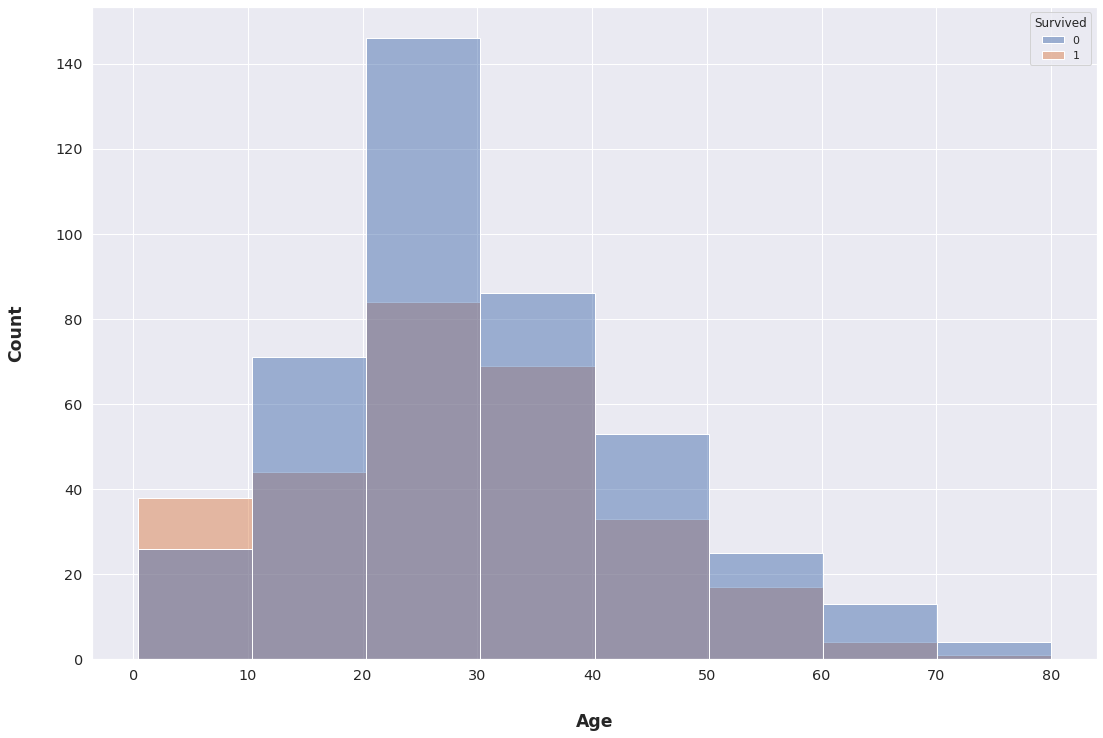

In [ ]:
# distribution of survival by 'Age'
sns.histplot(data=train, x='Age', hue='Survived', bins=8)
plt.show()

In [ ]:
# function to plot missing values
def plot_null(df):
    df_null = df.isnull().sum()
    null = df_null[df_null>0]
    null.sort_values(inplace=True)
    null.plot.bar()

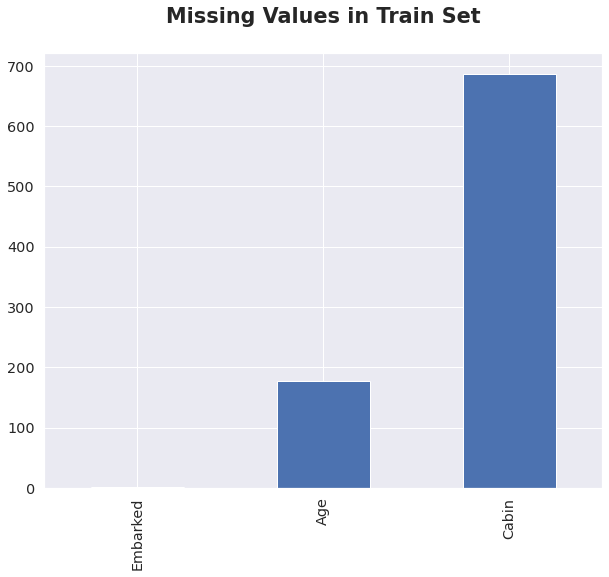

In [ ]:
plt.figure(figsize=(10,8))
plot_null(train)
plt.title('Missing Values in Train Set')
plt.show()

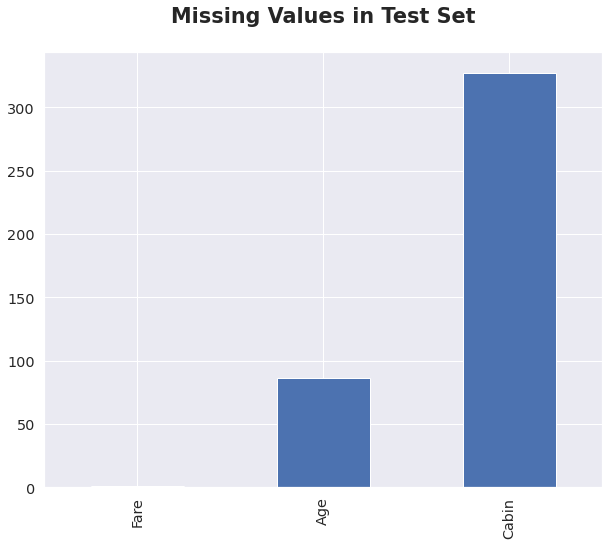

In [ ]:
plt.figure(figsize=(10,8))
plot_null(test)
plt.title('Missing Values in Test Set')
plt.show()

## **Embarked**

In [ ]:
# null values of 'Embarked'
# both passengers with null 'Embarked' values share 'Sex' and 'Pclass'
idx = df_all[df_all['Embarked'].isnull()].index
df_all.iloc[idx,:]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,1.0,1,female,38.0,0,0,113572,80.0,B28,NaN
829,1.0,1,female,62.0,0,0,113572,80.0,B28,NaN


In [ ]:
# create temporary dataframe of passengers who share these characteristics
temp_data = train[(train['Sex'] == 'female') & (train['Pclass'] == 1)]

# find most common 'Embarked' value for this dataframe
temp_data['Embarked'].value_counts()

S    48
C    43
Q     1
Name: Embarked, dtype: int64

In [ ]:
# impute with this value
for data in [train, test]:
  data['Embarked'].fillna('S', inplace=True)

## **Fare**

In [ ]:
# null values of 'Fare'
idx = df_all[df_all['Fare'].isnull()].index
df_all.iloc[idx,:]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1043,NaN,3,male,60.5,0,0,3701,NaN,NaN,S


In [ ]:
# create temporary dataframe of passengers with same 'Embarked' value
temp_data = train[train['Embarked'] == 'S']

# look at median fare for third class males
temp_data[['Pclass', 'Fare', 'Sex']].groupby(['Pclass','Sex'], as_index=False).median()

,Pclass,Sex,Fare
0,1,female,79.825
1,1,male,35.000
2,2,female,23.000
3,2,male,13.000
4,3,female,14.450
5,3,male,8.050


In [ ]:
# impute with this value
for data in [train, test]:
  data['Fare'].fillna(8.05, inplace=True)

## **Cabin**

In [ ]:
for data in [train, test]:
  # fill all nan values with 'N' for nan
  data['Cabin'].fillna('N', inplace=True)

  # group cabins by the first index of the string, which indicates cabin grouping
  data['Cabin'] = data['Cabin'].apply(lambda x: x[0])

In [ ]:
# survival rate by 'Cabin'
train[['Cabin', 'Survived']].groupby('Cabin', as_index=False).mean().sort_values(by='Survived', ascending=False)

,Cabin,Survived
3,D,0.757576
4,E,0.750000
1,B,0.744681
5,F,0.615385
2,C,0.593220
6,G,0.500000
0,A,0.466667
7,N,0.299854
8,T,0.000000


## **SibSp**

In [ ]:
# survival rate by 'SibSp'
train[['SibSp', 'Survived']].groupby('SibSp', as_index=False).mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


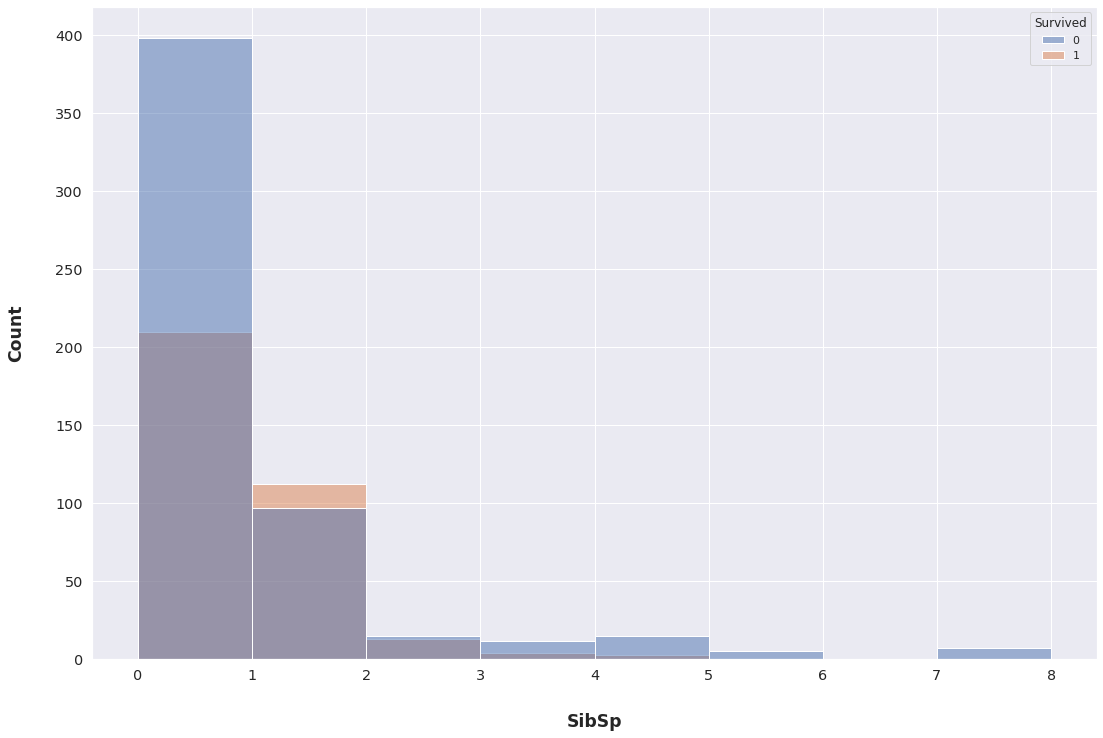

In [ ]:
# survival distribution by 'SibSp'
sns.histplot(data=train, x='SibSp', hue='Survived', bins=8)
plt.show()

In [ ]:
# function to group 'SibSp' values
def sibsp_bins(num):
  if num > 2:
    return 'more_than_two'
  elif num > 0:
    return 'one-two'
  else:
    return 'none'

for data in all_data:
  data['SibSp'] = data['SibSp'].apply(lambda x: sibsp_bins(x))

## **Parch**

In [ ]:
# survival rate by 'Parch'
train[['Parch', 'Survived']].groupby('Parch', as_index=False).mean()

,Parch,Survived
0,0,0.343658
1,1,0.550847
2,2,0.500000
3,3,0.600000
4,4,0.000000
5,5,0.200000
6,6,0.000000


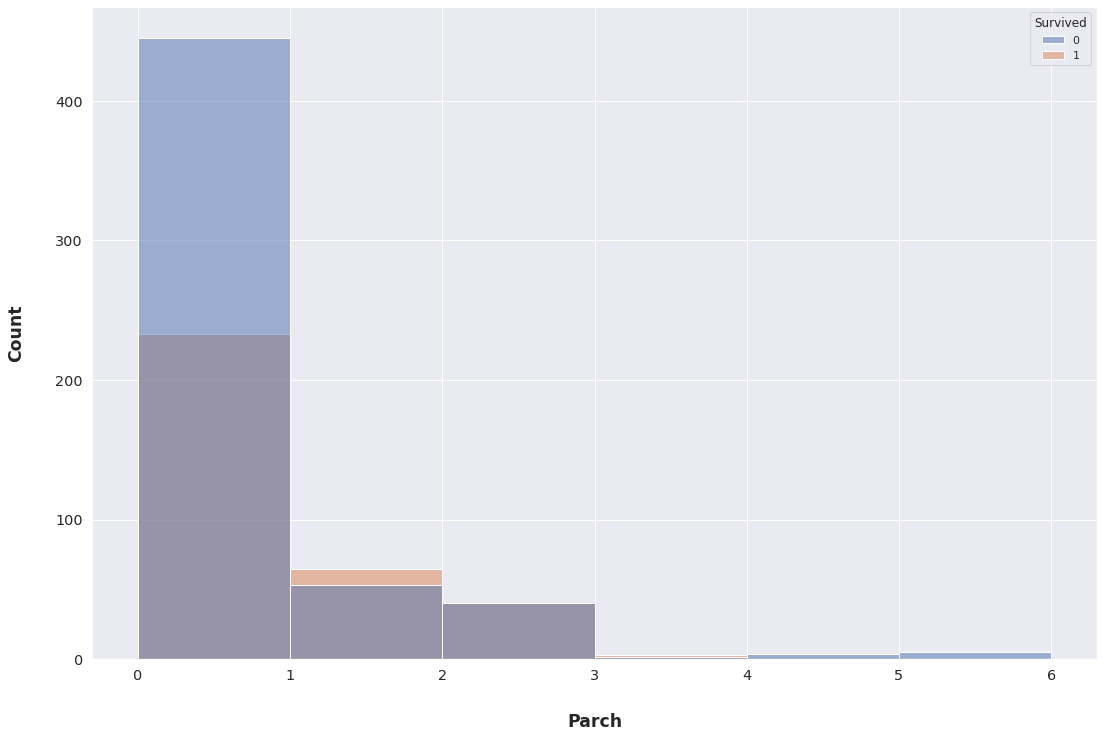

In [ ]:
# survival distribution by 'Parch'
sns.histplot(data=train, x='Parch', hue='Survived', bins=6)

In [ ]:
# function to group 'Parch' values
def parch_bins(num):
  if num > 3:
    return 'more_than_three'
  elif num > 0:
    return 'one-three'
  else:
    return 'none'

for data in [train, test]:
  data['Parch'] = data['Parch'].apply(lambda x: parch_bins(x))

## **Ticket**

In [ ]:
import string

# function format_ticket strips punctuation from string
# if ticket does not contain prefix letter, 'None' is inserted in place of prefix
def format_ticket(ticket):
  ticket = ticket.translate(str.maketrans('', '', string.punctuation))
  if ticket.isalnum():
    prefix = 'None '
    ticket = prefix + str(ticket)
  return ticket

all_data = pd.concat([train, test]).reset_index(drop=True)

all_data['Ticket'] = all_data['Ticket'].apply(lambda x: format_ticket(x))
# create new features TicketPrefix and TicketNumber from Ticket
all_data[['TicketPrefix','TicketNumber']] = all_data['Ticket'].str.split(' ', 1, expand=True)
# ticket prefix adds alot of noise, may drop this feature
all_data['TicketPrefix'].value_counts()

None       961
PC          92
CA          68
A5          28
SOTONOQ     24
WC          15
SCPARIS     14
STONO       14
A4          10
FCC          9
SOC          8
C            8
STONO2       7
SOPP         7
SCParis      5
SCAH         5
PP           4
WEP          4
SOTONO2      3
FC           3
SC           2
PPP          2
SCA4         2
SWPP         2
LP           1
CASOTON      1
SCA3         1
AQ4          1
A            1
SP           1
Fa           1
SCOW         1
SOP          1
STONOQ       1
AQ3          1
AS           1
Name: TicketPrefix, dtype: int64

In [ ]:
all_data['TicketNumber'] = all_data['TicketNumber'].apply(lambda x: str(x[0]))
# TicketNumber doesn't add too much noise. There are distinct differences in survival rate between values, feature may be worth keeping
#all_data[['TicketNumber','Survived']].groupby('TicketNumber', as_index=False).mean()
all_data['TicketNumber'].value_counts()

3    516
2    364
1    342
4     22
6     21
7     20
5      9
8      5
9      5
L      4
B      1
Name: TicketNumber, dtype: int64

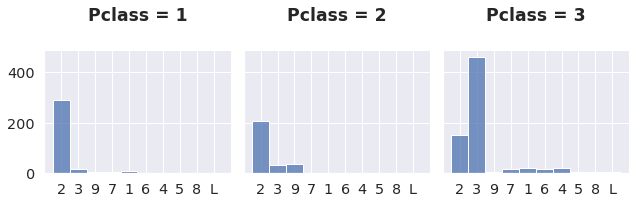

In [ ]:
g = sns.FacetGrid(data=all_data, col='Pclass')
g.map_dataframe(sns.histplot, x='TicketNumber')
plt.show()

In [ ]:
# passengers with TicketNumber value 'L', did not have an actual ticket number
idx = all_data[all_data['TicketNumber'] == 'L'].index
all_data.iloc[idx,:]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TicketPrefix,TicketNumber
179,0.0,3,male,36.0,none,none,None LINE,0.0,N,S,None,L
271,1.0,3,male,25.0,none,none,None LINE,0.0,N,S,None,L
302,0.0,3,male,19.0,none,none,None LINE,0.0,N,S,None,L
597,0.0,3,male,49.0,none,none,None LINE,0.0,N,S,None,L


In [ ]:
# function format_ticket did not properly parse this ticket value because of the extra space
# input a 'TicketNumber' value manually
idx = all_data[all_data['TicketNumber'] == 'B'].index
all_data.iloc[idx,:]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,TicketPrefix,TicketNumber
473,1.0,2,female,23.0,none,none,SCAH Basle 541,13.7917,D,C,SCAH,B


In [ ]:
all_data['TicketNumber'].at[idx] = '5'

In [ ]:
all_data.drop(columns=['Ticket', 'TicketPrefix'], inplace=True)
train = all_data.iloc[:train_length, :]
test = all_data.iloc[train_length:, :]

## **Fare**

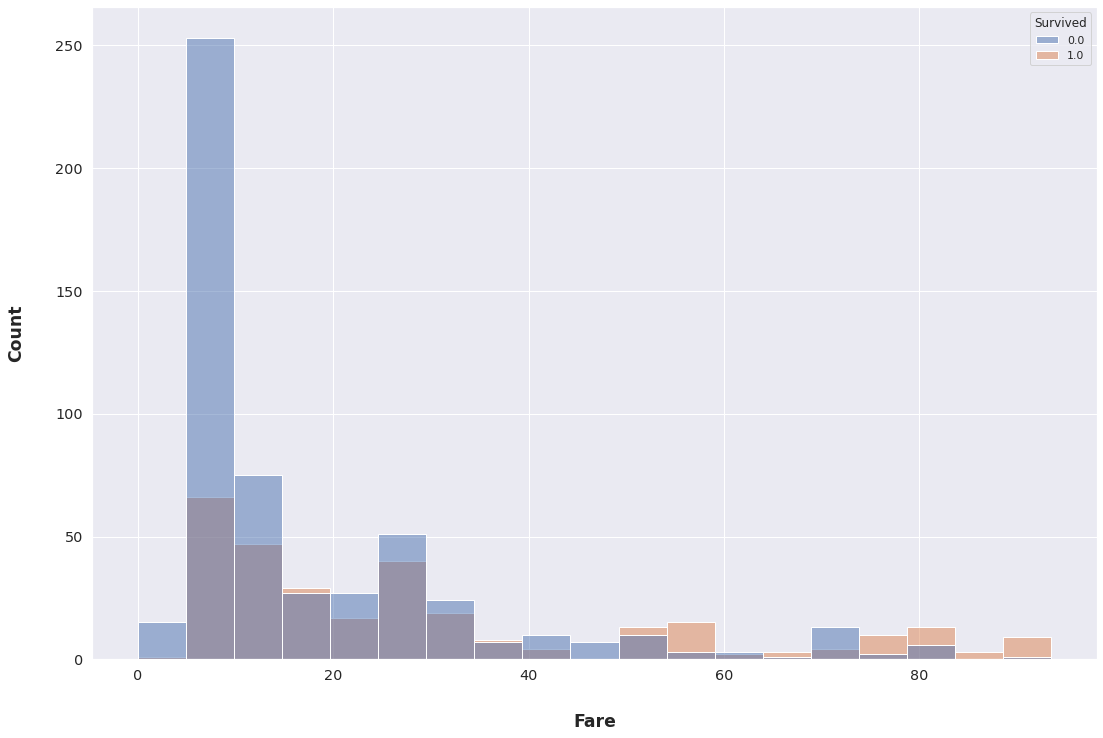

In [ ]:
sns.histplot(data=train[train['Fare']<100], x='Fare', hue='Survived', bins=19)

In [ ]:
train['Fare'].max()

512.3292

In [ ]:
bins = [0,15,50,515]
labels = [i for i in range(1,len(bins))]
train['Fare'] = pd.cut(train['Fare'], bins=bins, labels=labels, include_lowest=True)
train[['Fare', 'Survived']].groupby(['Fare'], as_index=False).mean().sort_values(by='Fare', ascending=True)

,Fare,Survived
0,1,0.248908
1,2,0.435897
2,3,0.681250


In [ ]:
test['Fare'] = pd.cut(test['Fare'], bins=bins, labels=labels, include_lowest=True)
for data in [train, test]:
  data['Fare'] = data['Fare'].astype('float64')

In [ ]:
from sklearn.impute import SimpleImputer
import pickle

# fit imputers to train set which will be used later during model deployment
num_cols = train.drop(columns=['Survived']).select_dtypes(exclude='object').columns
cat_cols = train.select_dtypes(include='object').columns
num_train = train[num_cols]
cat_train = train[cat_cols]
median_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
mode_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
median_imputer.fit(num_train)
mode_imputer.fit(cat_train)

# save imputers
with open('titanic_mode_imputer', 'wb') as file:
    pickle.dump((mode_imputer), file)
with open('titanic_median_imputer', 'wb') as file:
  pickle.dump((median_imputer), file)

## **Age**

In [ ]:
# use bayesian ridge to predict missing age values
# a dataframe with one hot encoded categorical variables is required for bayesian ridge predictor
from sklearn.preprocessing import OneHotEncoder

all_data = pd.concat([train, test]).reset_index(drop=True)

cat_cols = all_data.select_dtypes(include='object').columns
cat_data = all_data[cat_cols]
all_data.drop(columns=cat_cols, inplace=True)

encoder = OneHotEncoder(sparse=False)
encoder.fit(cat_data)
cat_data_transformed = pd.DataFrame(encoder.transform(cat_data), columns=encoder.get_feature_names(list(cat_cols)))

# save encoder for use during deployment
with open('titanic_encoder', 'wb') as file:
    pickle.dump((encoder), file)

all_data = pd.concat([all_data, cat_data_transformed], axis=1)
train = all_data.iloc[ :train_length,:]
test = all_data.iloc[train_length: ,:]

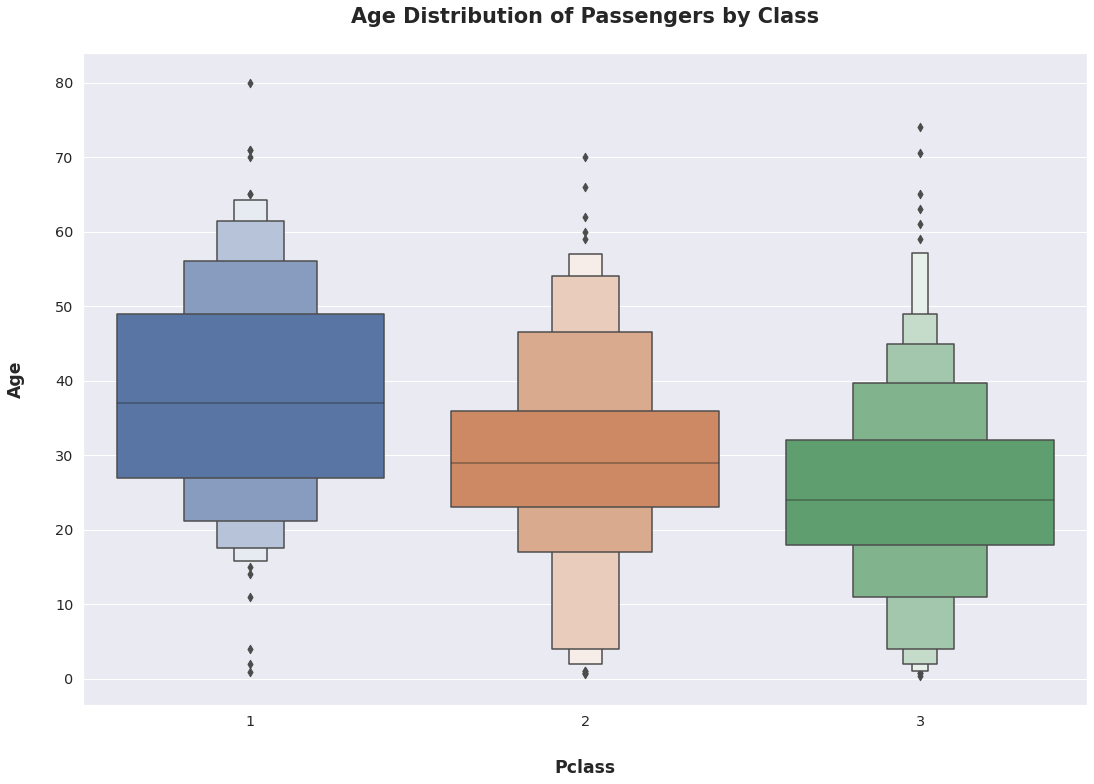

In [ ]:
sns.boxenplot(data=train, x='Pclass', y='Age')
plt.title('Age Distribution of Passengers by Class')
plt.show()

Text(0.5, 1.0, 'Age Distribution of Passengers')

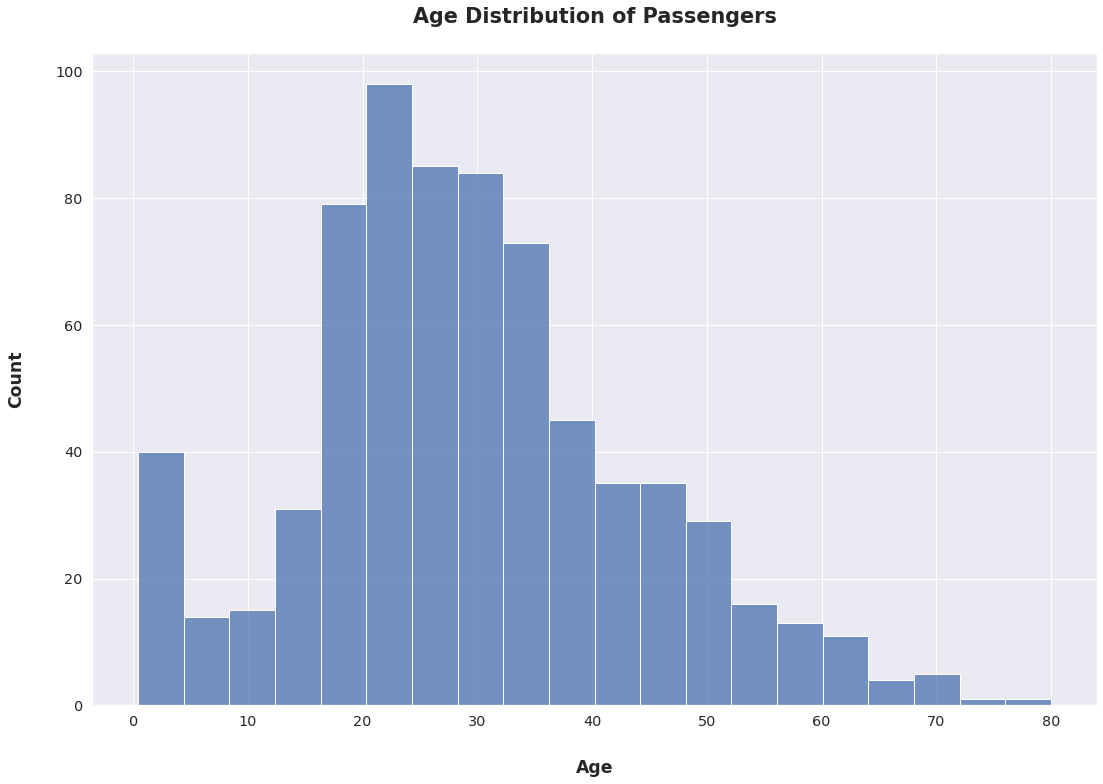

In [ ]:
sns.histplot(data=train, x='Age', bins=20)
plt.title('Age Distribution of Passengers')

Text(0.5, 1.0, 'Age Distribution of Passengers')

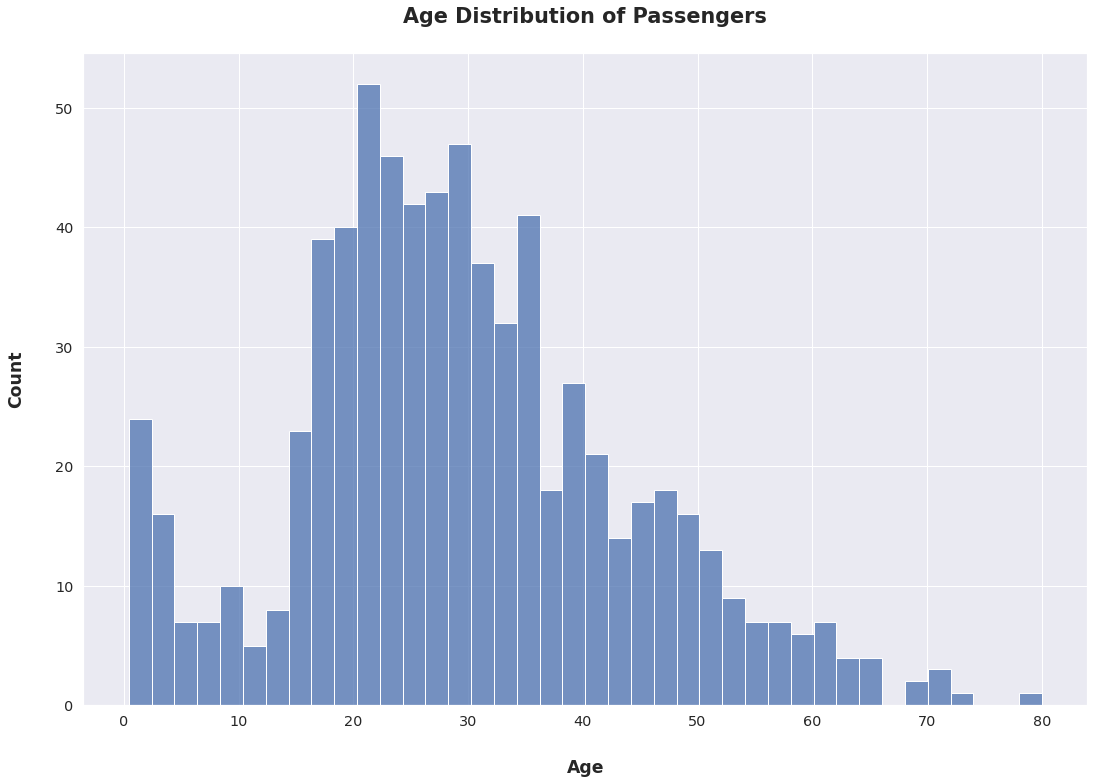

In [ ]:
sns.histplot(data=train, x='Age', bins=40)
plt.title('Age Distribution of Passengers')

In [ ]:
train['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Survived               891 non-null    float64
 1   Pclass                 891 non-null    int64  
 2   Age                    714 non-null    float64
 3   Fare                   891 non-null    float64
 4   Sex_female             891 non-null    float64
 5   Sex_male               891 non-null    float64
 6   SibSp_more_than_two    891 non-null    float64
 7   SibSp_none             891 non-null    float64
 8   SibSp_one-two          891 non-null    float64
 9   Parch_more_than_three  891 non-null    float64
 10  Parch_none             891 non-null    float64
 11  Parch_one-three        891 non-null    float64
 12  Cabin_A                891 non-null    float64
 13  Cabin_B                891 non-null    float64
 14  Cabin_C                891 non-null    float64
 15  Cabin_

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer = IterativeImputer(BayesianRidge(), min_value=1, max_value=80, max_iter=100)

columns = train.columns

# fit imputer to train set and use fitted imputer to transform both train and test set
imputer.fit(train)
train = pd.DataFrame(imputer.transform(train), columns=columns)
test = pd.DataFrame(imputer.transform(test), columns=columns)

In [ ]:
train['Age'].describe()

count    891.000000
mean      29.508628
std       13.465296
min        0.420000
25%       21.587748
50%       29.000000
75%       36.000000
max       80.000000
Name: Age, dtype: float64

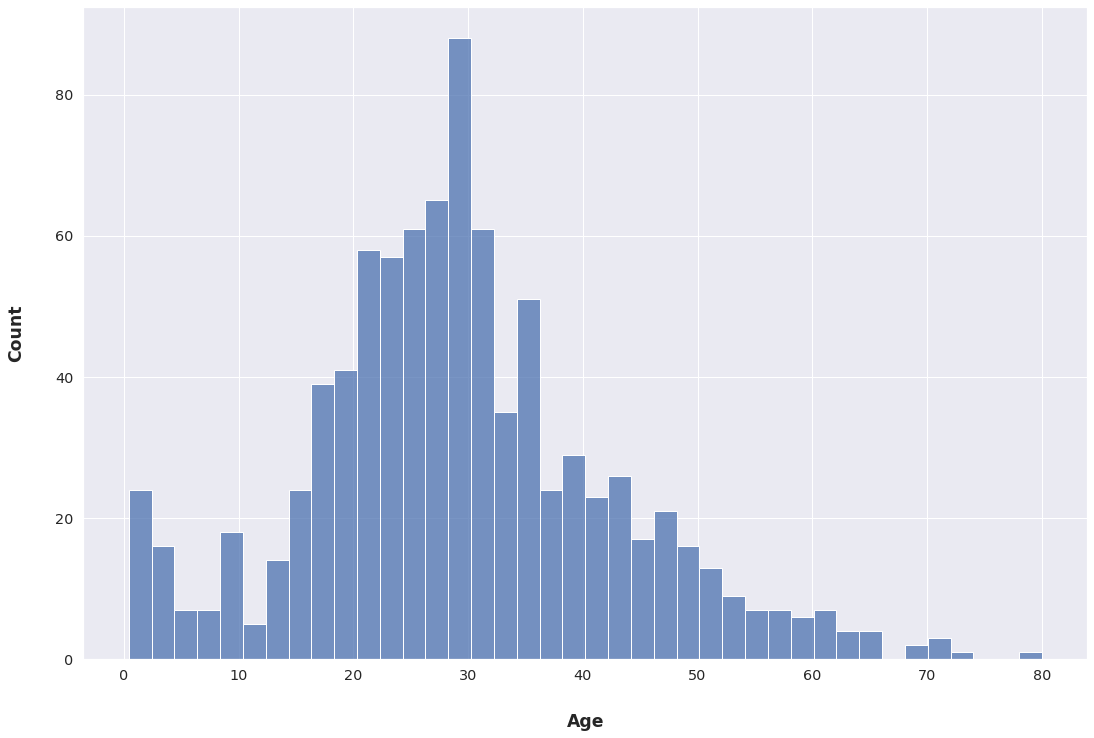

In [ ]:
# newly imputed values are in range of 20-32, generally around the mean
sns.histplot(data=train, x='Age', bins=40)
plt.show()

In [ ]:
bins = [0,5,15,60,81]
labels = [1,2,3,4]
train['Age'] = pd.cut(train['Age'], bins=bins, labels=labels, include_lowest=True)
train[['Age', 'Survived']].groupby(['Age'], as_index=False).mean().sort_values(by='Age', ascending=True)

,Age,Survived
0,1,0.704545
1,2,0.407407
2,3,0.368353
3,4,0.227273


In [ ]:
test['Age'] = pd.cut(test['Age'], bins=bins, labels=labels, include_lowest=True)
for data in [train, test]:
  data['Age'] = data['Age'].astype('float64')

In [ ]:
y_train = train['Survived']
X_train = train.drop(columns=['Survived'])
X_test = test.drop(columns=['Survived'])

In [ ]:
folds = KFold(n_splits=10, random_state=28, shuffle=True)

In [ ]:
def cv(model, X, y, folds):
    acc = cross_val_score(model, X, y, scoring='accuracy',
                                   cv=folds)
    return acc

In [ ]:
def bayes_search(estimator, search_space, folds, n_iter):
  cv = BayesSearchCV(estimator, search_space, n_iter=n_iter, n_jobs=-1, cv=folds, scoring='accuracy', verbose=0, random_state=28)
  cv.fit(X_train, y_train)

  print('best parameters:', '{')
  for key,value in cv.best_params_.items():
    print('\t', key, ':', value)
  print('\t', '}')
  print('\n')
  print('best score:', cv.best_score_)

  return cv

# Logistic Regression

In [ ]:
log_reg = LogisticRegression(random_state=28, max_iter=100000)
score = cv(log_reg, X_train, y_train, folds)
print(score.mean())

0.8204119850187265


In [ ]:
log_reg.fit(X_train, y_train)
with open('log_reg', 'wb') as file:
    pickle.dump(log_reg, file)

# XGB

In [ ]:
xgb = XGBClassifier(objective='binary:logistic',
                       nthread=-1,
                       seed=28,
                       random_state=28,
                    n_jobs=-1)

In [ ]:
params = {'learning_rate': [.0001, .0005, .001],
          'n_estimators': [8000,16000]}
xgb_bayes_cv = bayes_search(xgb, params, folds, 75)

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packa

best parameters: {
	 learning_rate : 0.0005
	 n_estimators : 10603
	 }


best score: 0.8260381593714927


In [ ]:
xgb.set_params(learning_rate=.0005, n_estimators=10603)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.0005, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=10603, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=28,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=28,
              silent=None, subsample=1, verbosity=1)

In [ ]:
params = {'max_depth': [2,10],
          'min_child_weight': [0,10]}
xgb_bayes_cv = bayes_search(xgb, params, folds, 25)

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packa

best parameters: {
	 max_depth : 2
	 min_child_weight : 6
	 }


best score: 0.8316498316498316


In [ ]:
xgb.set_params(max_depth=2, min_child_weight=6)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.0005, max_delta_step=0, max_depth=2,
              min_child_weight=6, missing=None, n_estimators=10603, n_jobs=-1,
              nthread=-1, objective='binary:logistic', random_state=28,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=28,
              silent=None, subsample=1, verbosity=1)

In [ ]:
params = {'gamma': [0.0,100.0],
          'reg_alpha': [0.0,100.0],
          'reg_lambda': [0.0,100.0]}
xgb_bayes_cv = bayes_search(xgb, params, folds, 25)

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


best parameters: {
	 gamma : 0.0
	 reg_alpha : 0.0
	 reg_lambda : 0.0
	 }


best score: 0.8316498316498316


In [ ]:
params = {'colsample_bytree': [.6,.7,.8,.9,1.0],
          'subsample': [.6,.7,.8,.9,1.0]}
xgb_bayes_cv = bayes_search(xgb, params, folds, 25)

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packa

best parameters: {
	 colsample_bytree : 1.0
	 subsample : 1.0
	 }


best score: 0.8316498316498316


In [ ]:
score = cv(xgb, X_train, y_train, folds)
print(score.mean())

0.8316354556803995


In [ ]:
xgb.fit(X_train, y_train)
with open('xgb_titanic', 'wb') as file:
    pickle.dump(xgb, file)

# LGBM

In [ ]:
lgbm = LGBMClassifier(objective='binary', random_state=28, seed=28, verbose=0, nthread=-1)

In [ ]:
params = {'learning_rate': [.001],
          'n_estimators': [6000, 16000]}
lgbm_bayes_cv = bayes_search(lgbm, params, folds, 50)

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packa

best parameters: {
	 learning_rate : 0.001
	 n_estimators : 7580
	 }


best score: 0.8226711560044894


In [ ]:
lgbm.set_params(learning_rate=.001, n_estimators=7580)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.001, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=7580, n_jobs=-1, nthread=-1, num_leaves=31,
               objective='binary', random_state=28, reg_alpha=0.0,
               reg_lambda=0.0, seed=28, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, verbose=0)

In [ ]:
params = {'max_depth': [2,10],
          'min_child_weight': [0,10]}
lgbm_bayes_cv = bayes_search(lgbm, params, folds, 25)

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packa

best parameters: {
	 max_depth : 2
	 min_child_weight : 2
	 }


best score: 0.8237934904601572


In [ ]:
lgbm.set_params(max_depth=2, min_child_weight=2)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.001, max_depth=2,
               min_child_samples=20, min_child_weight=2, min_split_gain=0.0,
               n_estimators=7580, n_jobs=-1, nthread=-1, num_leaves=31,
               objective='binary', random_state=28, reg_alpha=0.0,
               reg_lambda=0.0, seed=28, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, verbose=0)

In [ ]:
params = {'gamma': [0.0, 100.0],
          'reg_alpha': [0.0, 100.0],
          'reg_lambda':[0.0, 100.0]}
lgbm_bayes_cv = bayes_search(lgbm, params, folds, 30)

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


best parameters: {
	 gamma : 12.170282736125973
	 reg_alpha : 3.2876634055867613
	 reg_lambda : 0.5005549954364309
	 }


best score: 0.8294051627384961


In [ ]:
lgbm.set_params(gamma=12.170282736125973, reg_alpha=3.2876634055867613, reg_lambda=0.5005549954364309)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               gamma=12.170282736125973, importance_type='split',
               learning_rate=0.001, max_depth=2, min_child_samples=20,
               min_child_weight=2, min_split_gain=0.0, n_estimators=7580,
               n_jobs=-1, nthread=-1, num_leaves=31, objective='binary',
               random_state=28, reg_alpha=3.2876634055867613,
               reg_lambda=0.5005549954364309, seed=28, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
               verbose=0)

In [ ]:
score = cv(lgbm, X_train, y_train, folds)
print(score.mean())

0.8293882646691635


In [ ]:
lgbm.fit(X_train, y_train)
with open('lgbm_titanic', 'wb') as file:
    pickle.dump(lgbm, file)

# Ensemble

In [ ]:
with open('lgbm_titanic', 'rb') as handle:
    lgbm = pickle.load(handle)
with open('xgb_titanic', 'rb') as handle:
    xgb = pickle.load(handle)
with open('log_reg_titanic', 'rb') as handle:
    log_reg = pickle.load(handle)

In [ ]:
from sklearn.ensemble import VotingClassifier

voter = VotingClassifier(estimators=[('log_reg', log_reg),
              ('xgb', xgb),
              ('lgbm', lgbm)],
              voting='hard',
              n_jobs=-1)

In [ ]:
score = cv(voter, X_train, y_train, folds)
print(score.mean())

0.8293882646691635


In [ ]:
voter.fit(X_train, y_train)

VotingClassifier(estimators=[('log_reg',
                              LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100000,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=28,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False)),
                             ('xgb',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1...
                                             min_child_samples=20,
                                   

In [ ]:
with open('voter_titanic', 'wb') as file:
  pickle.dump(voter, file)

In [ ]:
with open('voter_titanic', 'rb') as handle:
  voter = pickle.load(handle)

In [ ]:
predictions = voter.predict(X_test)
results = pd.read_csv('gender_submission.csv')
results['Survived'] = predictions

In [ ]:
results.to_csv('gender_submission.csv')